In [2]:
import sys

In [3]:
sys.path.append('/astro/store/epyc/users/brycek/siggi/')

In [4]:
from siggi import siggi, filters, spectra, calcIG, plotting
from siggi import Sed
from siggi.lsst_utils import Bandpass, BandpassDict, PhotometricParameters
import matplotlib.pyplot as plt
import numpy as np
import os
%load_ext autoreload
%autoreload 2
%matplotlib inline

/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
import sncosmo

In [6]:
import seaborn as sbs
sbs.set()

## Create two types of SN spectra

In [33]:
model_ia = sncosmo.Model(source='nugent-sn1a')
model_ia.set(z=0.7, t0=0., amplitude=1.e-10)

In [34]:
model_iip = sncosmo.Model(source='nugent-sn2p')
model_iip.set(z=0.7, t0=0., amplitude=1.e-10)

In [35]:
wave = np.arange(3000., 12000., 0.1)

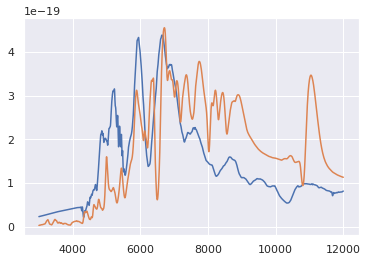

In [36]:
plt.plot(wave, model_ia.flux(20., wave))
plt.plot(wave, model_iip.flux(20., wave))

In [37]:
model_ia.bandmag('lsstu', 'ab', [10., 20.])

array([31.14742333, 28.37300846])

## Use siggi

In [39]:
f = filters()
s = spectra()

In [43]:
ia_spec = Sed()
ia_spec.setSED(wavelen=wave/10., flambda=model_ia.flux(20., wave))

In [44]:
iip_spec = Sed()
iip_spec.setSED(wavelen=wave/10., flambda=model_iip.flux(20., wave))

In [45]:
def flat_prior_2(z):
    z_out = np.ones(len(z))
    z_out[0] = 0.
    return z_out

In [46]:
d_lambda = 25.
x = np.arange(375., 1026., d_lambda)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(387.5, 1026., d_lambda)
for val_1 in y:
    point_list.append([val_1, val_1])

In [48]:
bp_list = []
bp_dir = '../siggi/siggi/data/lsst_baseline_throughputs/'
for filter_name in ['u', 'g', 'r', 'i', 'z', 'y']:
    current_bp = Bandpass()
    print(os.path.join(bp_dir, 'filter_%s.dat' % filter_name))
    current_bp.readThroughput(os.path.join(bp_dir, 'filter_%s.dat' % filter_name))
    bp_list.append(current_bp)

../siggi/siggi/data/lsst_baseline_throughputs/filter_u.dat
../siggi/siggi/data/lsst_baseline_throughputs/filter_g.dat
../siggi/siggi/data/lsst_baseline_throughputs/filter_r.dat
../siggi/siggi/data/lsst_baseline_throughputs/filter_i.dat
../siggi/siggi/data/lsst_baseline_throughputs/filter_z.dat
../siggi/siggi/data/lsst_baseline_throughputs/filter_y.dat


In [49]:
bp_dict = BandpassDict(bp_list, ['u', 'g', 'r', 'i', 'z', 'y'])

In [50]:
new_phot_params = {}

new_phot_params['filter_0'] = PhotometricParameters(nexp=2, bandpass='any')
new_phot_params['filter_1'] = PhotometricParameters(nexp=2, bandpass='any')

In [51]:
f_norm = ia_spec.calcFluxNorm(22., bp_dict['i'])
ia_spec.multiplyFluxNorm(f_norm)
f_norm = iip_spec.calcFluxNorm(22., bp_dict['i'])
iip_spec.multiplyFluxNorm(f_norm)

In [52]:
filt_edges = []
for point_loc in point_list:
    filt_edges.append([point_loc[0]-50., point_loc[0]+50., point_loc[1]-50., point_loc[1]+50.])

In [53]:
ig_vals = []
filt_edges = []
for point_loc in point_list:
    if len(ig_vals) % 50 == 0:
        print('%i out of %i' % (len(ig_vals), len(point_list)))
    filt_new = f.trap_filters([[point_loc[0]-50., point_loc[0]-25., point_loc[0]+25., point_loc[0]+50.],
                               [point_loc[1]-50., point_loc[1]-25., point_loc[1]+25., point_loc[1]+50.]])
    filt_edges.append([point_loc[0]-50., point_loc[0]+50., point_loc[1]-50., point_loc[1]+50.])
    c = calcIG(filt_new, [[ia_spec], [iip_spec]], [0.0, 1.0, 1.0], [0, 1, 2], phot_params=new_phot_params, ref_filter=bp_dict['i'], n_pts=10000)
    ig_vals.append(c.calc_IG(rand_state=np.random.RandomState(42)))

0 out of 755
50 out of 755
100 out of 755
150 out of 755
200 out of 755
250 out of 755
300 out of 755
350 out of 755
400 out of 755
450 out of 755
500 out of 755
550 out of 755
600 out of 755
650 out of 755
700 out of 755
750 out of 755


In [54]:
max_idx = np.argmax(ig_vals)

best_pt = point_list[max_idx]


In [55]:
best_val = ig_vals[max_idx]

In [56]:
print(best_pt, best_val)

[575.0, 850.0] 0.9998333334507481


In [57]:
best_filter = [best_pt[0]-50., best_pt[0]+50., best_pt[1]-50., best_pt[1]+50.]

In [58]:
sig_plot = plotting([ia_spec, iip_spec], best_filter,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)

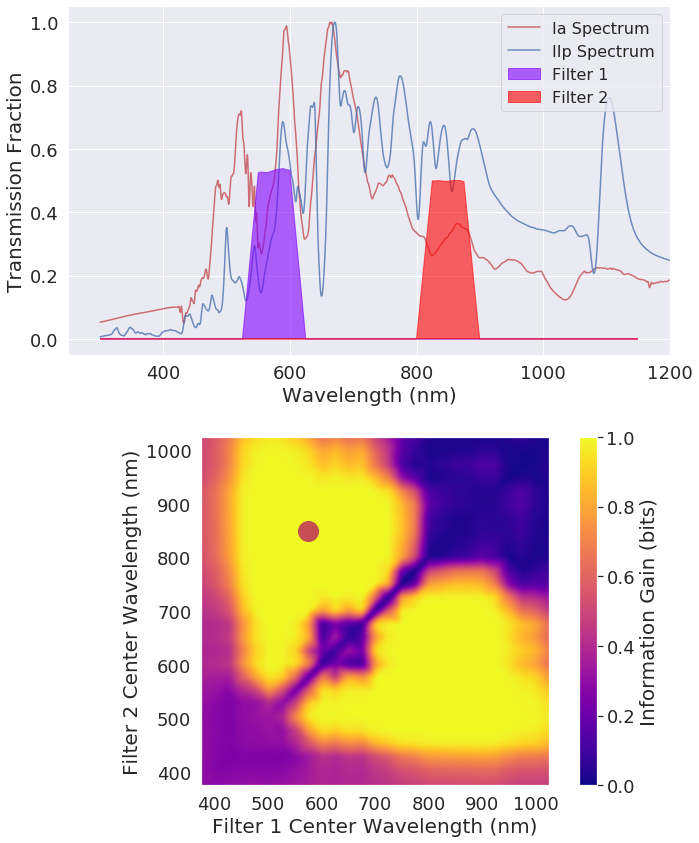

In [61]:
fig = plt.figure(figsize=(10, 12))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
ax.lines[0].set_color('r')
ax.lines[1].set_color('b')
ax.lines[0].set_alpha(0.8)
ax.lines[1].set_alpha(0.8)
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Ia Spectrum', 'IIp Spectrum', 'Filter 1', 'Filter 2'), loc=1, fontsize=16)
plt.xticks(size=18)
plt.yticks(size=18)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(np.array(filt_edges), np.array(ig_vals), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)', size=20)
cbar.ax.tick_params(labelsize=18)
plt.scatter(best_pt[0], best_pt[1], c='r', s=400)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.grid(False)
plt.tight_layout()